## Test redshift independce

In [1]:
!pip install corner
!pip install -U emcee

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
%run 00_Dataset.ipynb

In [3]:
import pandas as pd
import numpy as np
import emcee
import corner
import os 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

In [4]:

data = (np.genfromtxt(
    in_filepath,
    skip_header=6, 
    names=True,
    comments='#')
)


In [5]:
GRB = pd.read_csv(os.path.join('../data/','GRB','GRB_data_Wang_et_al_2011.csv'))

In [6]:
re_mu = np.genfromtxt(os.path.join(out_dir,"reconstruction.csv"), delimiter=',')

In [7]:
# load the reconstructed data from RNN+BNN for dataset
GRB['mu'] = re_mu[0]
GRB['mu_err'] =  re_mu[1]

In [8]:
def calculate_dL(mu):
    '''
    dL is the luminosity distance of GRB, which can be obtained from the reconstructed distance moduli of Pantheon
    '''
    
    return 10**((mu-25)/5) * 10**6 * 3.086e+18

def calculate_dL_err(dL, mu_err):

    return abs(dL) * abs(np.log(10) * mu_err / 5.)

def calculate_L(d_L, P_bolo):

    '''
    Assuming that GRBs radiate isotropically, the isotropic equivalent
    luminosity can be derived from bolometric peak flux P_bolo
    '''

    return 4*np.pi*((d_L)**2)*P_bolo

def calculate_L_err(dL_err, dL, P_bolo_err, P_bolo, L):

    return abs(L) * np.sqrt((2. * dL_err / dL)**2 + (P_bolo_err / P_bolo)**2)

def calculate_E_iso(dL, S_bolo, z):
    '''
    The isotropic equivalent energy E_iso can be obtained from the 
    bolometric fluence S_bolo by
    '''

    return 4*np.pi*(dL)**2*S_bolo / (1+z)

def calculate_E_iso_err(L, dL_err, dL, S_bolo_err, S_bolo, z):
    
    return abs(L) * np.sqrt((2. * dL_err / dL)**2 + (S_bolo_err / S_bolo)**2) / (1+z)

def calculate_E_gamma(E_iso, F_beam):
    '''
    If GRBs radiate in two symmetric beams, then we can define the 
    collimation-corrected energy E_gamma as
    '''

    return E_iso * F_beam

def calculate_E_gamma_err(E_iso, F_beam, E_gamma, E_iso_err, F_beam_err):

    return abs(E_gamma) * np.sqrt((E_iso_err / E_iso)**2 + (F_beam_err / F_beam)**2 )

In [9]:
# get distance moduli for redshifts using reconstructed mu-z funciton
GRB['dL'] = calculate_dL(GRB['mu'].to_numpy()) 
GRB['dL_err'] = calculate_dL_err(GRB['dL'].to_numpy(), GRB['mu_err'].to_numpy())
GRB['L'] = calculate_L(GRB['dL'].to_numpy(), GRB['P_bolo'].to_numpy()) 
GRB['L_err'] = calculate_L_err(GRB['dL_err'].to_numpy(), GRB['dL'].to_numpy(), GRB['P_bolo_err'].to_numpy(), GRB['P_bolo'].to_numpy(), GRB['L'].to_numpy()) 
GRB['E_iso'] = calculate_E_iso(GRB['dL'].to_numpy(), GRB['S_bolo'].to_numpy(), GRB['z'].to_numpy())
GRB['E_iso_err'] = calculate_E_iso_err(GRB['L'].to_numpy(), GRB['dL_err'].to_numpy(), GRB['dL'].to_numpy(), GRB['S_bolo_err'].to_numpy(), GRB['S_bolo'].to_numpy(), GRB['z'].to_numpy())
GRB['E_gamma'] = calculate_E_gamma(GRB['E_iso'].to_numpy(), GRB['F_beam'].to_numpy())
GRB['E_gamma_err'] = calculate_E_gamma_err(GRB['E_iso'].to_numpy(), GRB['F_beam'].to_numpy(), GRB['E_gamma'].to_numpy(), GRB['E_iso_err'].to_numpy(), GRB['F_beam_err'].to_numpy())

In [10]:
# Since E_peak, error bars are asymmetric, just take the average of the lower and upper errors and then do the fit.
GRB['E_peak_err'] = GRB[['E_peak_err_min','E_peak_err_max']].mean(axis=1)

 quantities with a subscript ‘i’ indicate that they are measured in the comoving frame, which are related to the
quantities in the observer frame by τlag,i = τlag(1 + z)
−1
, τRT,i = τRT(1 + z)
−1
, Vi = V (1 + z) and Ep,i = Ep(1 + z)

In [11]:
GRB['T_lag_i'] = GRB['T_lag'] / (1. + GRB['z'])
GRB['T_lag_i_err'] = GRB['T_lag_err'] / (1. + GRB['z'])
GRB['T_RT_i'] = GRB['T_RT'] / (1. + GRB['z'])
GRB['T_RT_i_err'] = GRB['T_RT_err'] / (1. + GRB['z'])
GRB['V_i'] = GRB['V'] * (1. + GRB['z'])
GRB['V_i_err'] = GRB['V_err'] * (1. + GRB['z'])
GRB['E_peak_i'] = GRB['E_peak'] * (1. + GRB['z'])
GRB['E_peak_i_err'] = GRB['E_peak_err'] * (1. + GRB['z'])
GRB['E_peak_i_err_min'] = GRB['E_peak_err_min'] * (1. + GRB['z'])
GRB['E_peak_i_err_max'] = GRB['E_peak_err_max'] * (1. + GRB['z'])

In [12]:
# normalized
GRB['_T_lag_i'] = GRB['T_lag_i'] / 0.1
GRB['_T_lag_i_err'] = GRB['T_lag_i_err'] / 0.1
GRB['_V_i'] = GRB['V_i'] / 0.02
GRB['_V_i_err'] = GRB['V_i_err'] / 0.02
GRB['_E_peak_i'] = GRB['E_peak_i'] / 300
GRB['_E_peak_i_err'] = GRB['E_peak_i_err'] / 300
GRB['_E_peak_i_err_min'] = GRB['E_peak_i_err_min'] / 300
GRB['_E_peak_i_err_max'] = GRB['E_peak_i_err_max'] / 300
GRB['_T_RT_i'] = GRB['T_RT_i'] / 0.1
GRB['_T_RT_i_err'] = GRB['T_RT_i_err'] / 0.1

In [13]:
# log transformation
GRB['log_T_lag_i'] = np.log10(GRB['_T_lag_i'])
GRB['log_T_lag_i_err'] = abs(GRB['_T_lag_i_err'] / (GRB['_T_lag_i'] * np.log(10)))
GRB['log_V_i'] = np.log10(GRB['_V_i'])
GRB['log_V_i_err'] = abs(GRB['_V_i_err'] / (GRB['_V_i'] * np.log(10)))
GRB['log_E_peak_i'] = np.log10(GRB['_E_peak_i'])
GRB['log_E_peak_i_err'] = abs(GRB['_E_peak_i_err'] / (GRB['_E_peak_i'] * np.log(10)))
GRB['log_E_peak_i_err_min'] = abs(GRB['_E_peak_i_err_min'] / (GRB['_E_peak_i'] * np.log(10)))
GRB['log_E_peak_i_err_max'] = abs(GRB['_E_peak_i_err_max'] / (GRB['_E_peak_i'] * np.log(10)))
GRB['log_T_RT_i'] = np.log10(GRB['_T_RT_i'])
GRB['log_T_RT_i_err'] = abs(GRB['_T_RT_i_err'] / (GRB['_T_RT_i'] * np.log(10)))

/home/spb/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
GRB['log_L'] = np.log10(GRB['L'])
GRB['log_L_err'] = abs(GRB['L_err'] / (GRB['L'] * np.log(10)))
GRB['log_E_iso'] = np.log10(GRB['E_iso'])
GRB['log_E_iso_err'] = abs(GRB['E_iso_err'] / (GRB['E_iso'] * np.log(10)))
GRB['log_E_gamma'] = np.log10(GRB['E_gamma'])
GRB['log_E_gamma_err'] = abs(GRB['E_gamma_err'] / (GRB['E_gamma'] * np.log(10)))

In [15]:
# split the data in to low-z, high-z and All-z
low_z_GRB = GRB[GRB['z']<=1.4]
high_z_GRB = GRB[GRB['z']>1.4]
All_z_GRB = GRB

In [16]:
# filter GRBs seperately for each correlation, such that required data are present for each GRB
 

In [17]:
def log_likelihood(theta, x, y, xerr, yerr):
    b, a, sigma_int = theta
    model = b * x + a
    sigma2 = sigma_int**2 + yerr**2 + b**2 * xerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    b, a, sigma_int = theta
    if sigma_int > 0:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

/tmp/ipykernel_1217081/2226964974.py:95: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_1217081/2226964974.py:95: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_1217081/2226964974.py:95: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_1217081/2226964974.py:95: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_1217081/2226964974.py:95: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_12170

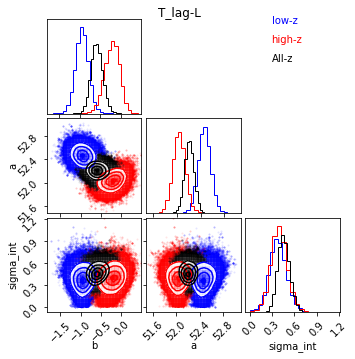

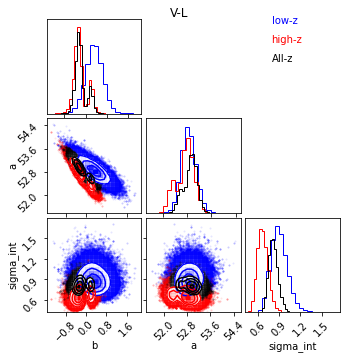

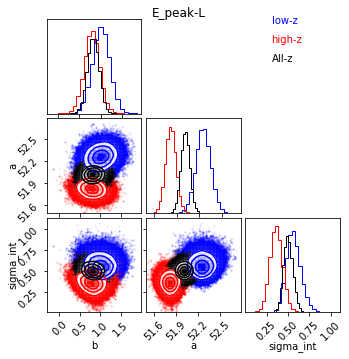

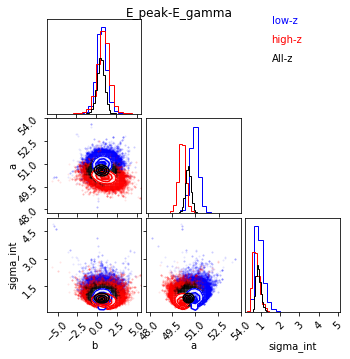

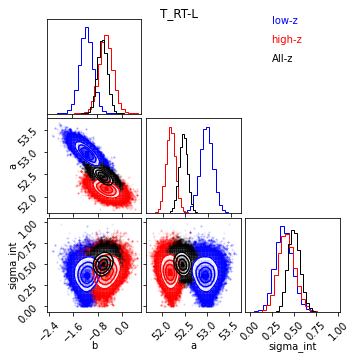

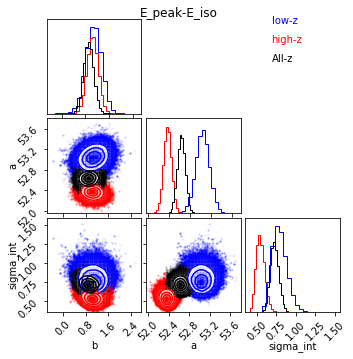

In [18]:
correlations = {
    'T_lag-L' : ('log_T_lag_i', 'log_L', 'log_T_lag_i_err', 'log_L_err'),
    'V-L' : ('log_V_i', 'log_E_iso', 'log_V_i_err', 'log_E_iso_err'),
    'E_peak-L' : ('log_E_peak_i', 'log_L', 'log_E_peak_i_err', 'log_L_err'),
    'E_peak-E_gamma' : ('log_E_peak_i', 'log_E_gamma', 'log_E_peak_i_err', 'log_E_gamma_err'),
    'T_RT-L' : ('log_T_RT_i', 'log_L', 'log_T_RT_i_err', 'log_L_err'),
    'E_peak-E_iso' : ('log_E_peak_i', 'log_E_iso', 'log_E_peak_i_err', 'log_E_iso_err')
}

# Calculate best fit line with uncertainities(Bayesian approach) using emcee
GRB_samples = (low_z_GRB, high_z_GRB, All_z_GRB)
sample_types =  ('low-z', 'high-z', 'All-z')
colors = ('b','r','k')

# MCMC parameters
nwalkers, ndim = 64, 3
nsteps, nburns = 10000, 5000

# empty dictionary to save best fit parameters and uncertainities
BestFitParameters = { 
    'T_lag-L':{'low-z':None, 'high-z':None, 'All-z':None},
    'V-L':{'low-z':None, 'high-z':None, 'All-z':None},
    'E_peak-L':{'low-z':None, 'high-z':None, 'All-z':None},
    'E_peak-E_gamma':{'low-z':None, 'high-z':None, 'All-z':None},
    'T_RT-L':{'low-z':None, 'high-z':None, 'All-z':None},
    'E_peak-E_iso':{'low-z':None, 'high-z':None, 'All-z':None}
}

num = 8
for i, correlation in enumerate(correlations):

    luminosities = correlations[correlation]

    '''
    # create empty figure object for time series (steps) plot of parameters in chain
    fig1 = plt.figure(constrained_layout=True, figsize=(15,5))
    gs1 = gridspec.GridSpec(nrows=1, ncols=3, figure=fig1)
    '''

    # create empty figure object for corner plots (confidence contours and marginalized PDFs of parameters)
    fig2 = plt.figure(figsize=(5, 5))
    fig2.patch.set_facecolor('white')

    for k, (GRB_sample, sample_type, color) in enumerate(zip(GRB_samples, sample_types, colors)):

        df = GRB_sample.filter(luminosities).dropna()
        
        x = df[luminosities[0]].to_numpy()
        y = df[luminosities[1]].to_numpy()
        xerr = df[luminosities[2]].to_numpy()
        yerr = df[luminosities[3]].to_numpy()

        starting_guesses = np.random.rand(nwalkers, ndim)
        
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, xerr, yerr))
        sampler.run_mcmc(starting_guesses, nsteps)

        labels = ['b', 'a', 'sigma_int']
        '''
        # time series plot of parameters
        samples = sampler.get_chain()
        gs11 = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=1, subplot_spec=gs1[k])

        for j in range(ndim):
            ax = fig1.add_subplot(gs11[j])
            ax.plot(samples[..., j], 'k', alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[j])
            ax.yaxis.set_label_coords(-0.1, 0.5)
        #axes[-1].set_xlabel("step number");
        '''
        # corner plots
        flat_samples = sampler.get_chain(discard=nburns, flat=True)
        corner.corner(flat_samples, labels=labels, color=color,fig=fig2)

        # save best fit values(mean) and uncertainities(std) of parameters in a dictionary
        BestFitParameters[correlation][sample_type] = {
                'a' : np.mean(flat_samples[:, 1]), 
                'a_err' : np.std(flat_samples[:, 1]),
                'b' : np.mean(flat_samples[:, 0]), 
                'b_err' : np.std(flat_samples[:, 0]),
                'sigma_int' : np.mean(flat_samples[:, 2]),
                'sigma_int_err' : np.std(flat_samples[:, 2])
        }
    
        fig2.axes[0].annotate(sample_type, xy=(0.95*2.5, 0.95-k*0.2), xycoords='axes fraction',color=color)
  
    fig2.suptitle(correlation)

    #fig1.savefig('time_series_of_params.png')
    num_str = '0' + str(num) if num < 10 else str(num)
    fig2.savefig(os.path.join(out_dir, num_str+'_'+correlation+'_corner_plot.png'))
    num += 1
    #fig1.show()
    fig2.show()

In [19]:
with open(os.path.join(out_dir, 'BestFitParameters.pickle'), 'wb') as handle:
    pickle.dump(BestFitParameters, handle)

In [20]:
with open(os.path.join(out_dir, 'BestFitParameters.pickle'), 'rb') as handle:
    BestFitParameters = pickle.load(handle)

In [21]:
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

table = nested_dict_to_df(BestFitParameters)

!pip install tabulate

from tabulate import tabulate

print(tabulate(table, headers='keys', tablefmt='fancy_grid'))

Defaulting to user installation because normal site-packages is not writeable
╒══════════════════════════════╤═════════╤═══════════╤═══════════╤══════════╤═════════════╤═════════════════╕
│                              │       a │     a_err │         b │    b_err │   sigma_int │   sigma_int_err │
╞══════════════════════════════╪═════════╪═══════════╪═══════════╪══════════╪═════════════╪═════════════════╡
│ ('E_peak-E_gamma', 'All-z')  │ 50.5608 │ 0.177052  │  0.56384  │ 0.452554 │    0.842596 │       0.139306  │
├──────────────────────────────┼─────────┼───────────┼───────────┼──────────┼─────────────┼─────────────────┤
│ ('E_peak-E_gamma', 'high-z') │ 50.1557 │ 0.234452  │  0.876624 │ 0.731559 │    0.72489  │       0.207622  │
├──────────────────────────────┼─────────┼───────────┼───────────┼──────────┼─────────────┼─────────────────┤
│ ('E_peak-E_gamma', 'low-z')  │ 50.9434 │ 0.274679  │  0.662839 │ 0.614152 │    0.909508 │       0.247112  │
├──────────────────────────────┼─────────┼

/tmp/ipykernel_1217081/2254155126.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


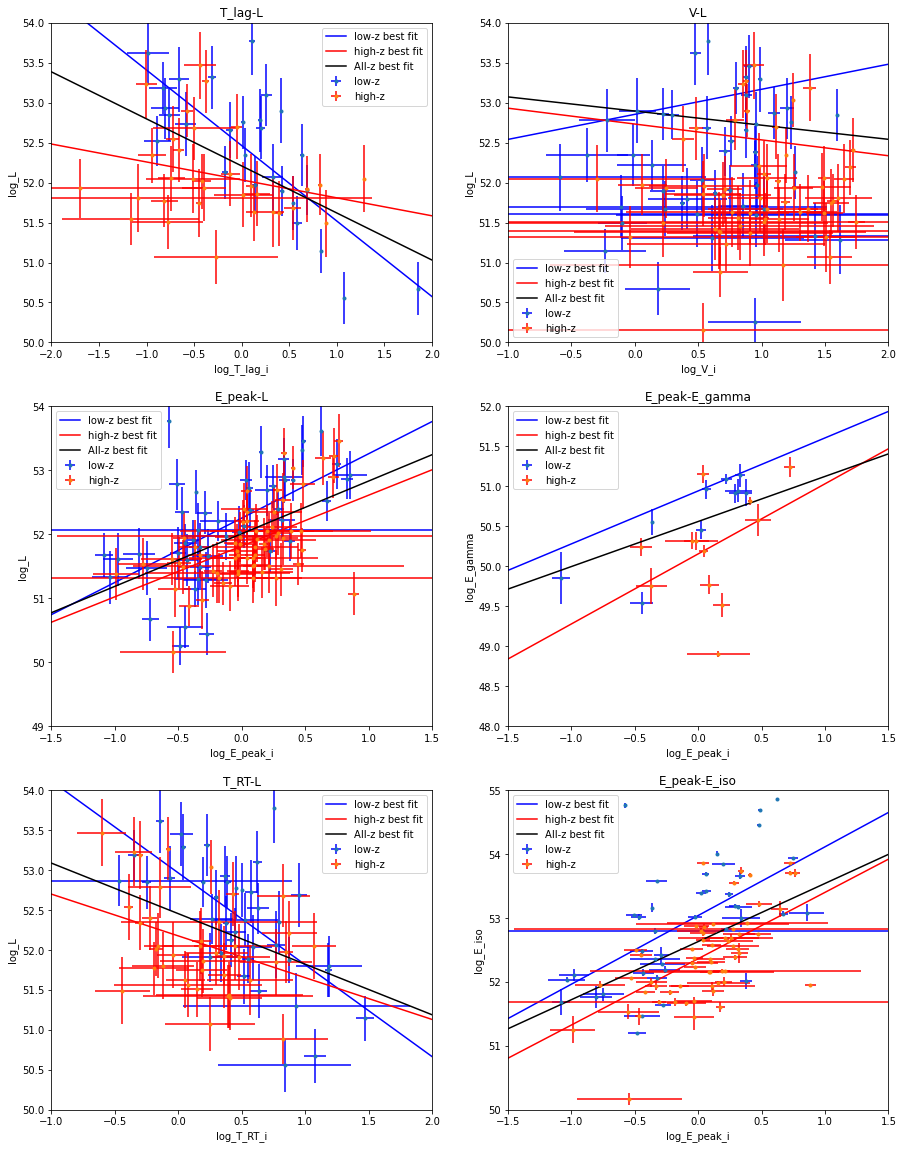

In [22]:
correlations = {
    'T_lag-L' : {'features': ('log_T_lag_i', 'log_L', 'log_T_lag_i_err', 'log_L_err'), 'ylim':(50, 54), 'xlim':(-2.0,2.0)},
    'V-L' : {'features': ('log_V_i', 'log_L', 'log_V_i_err', 'log_L_err'), 'ylim':(50, 54), 'xlim':(-1.0,2.0)},
    'E_peak-L' : {'features': ('log_E_peak_i', 'log_L', 'log_E_peak_i_err', 'log_L_err'), 'ylim':(49, 54), 'xlim':(-1.5,1.5)},
    'E_peak-E_gamma' : {'features': ('log_E_peak_i', 'log_E_gamma', 'log_E_peak_i_err', 'log_E_gamma_err'), 'ylim':(48, 52), 'xlim':(-1.5,1.5)},
    'T_RT-L' : {'features': ('log_T_RT_i', 'log_L', 'log_T_RT_i_err', 'log_L_err'), 'ylim':(50, 54), 'xlim':(-1.0,2.0)},
    'E_peak-E_iso' : {'features': ('log_E_peak_i', 'log_E_iso', 'log_E_peak_i_err', 'log_E_iso_err'), 'ylim':(50, 55), 'xlim':(-1.5,1.5)}
}

GRB_samples = (low_z_GRB, high_z_GRB, All_z_GRB)
sample_types =  ('low-z', 'high-z', 'All-z')
colors = ('b','r','k')

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,20))
fig.patch.set_facecolor('white')
# plot best fit for each luminosity correlation
for i, correlation in enumerate(correlations):

    luminosities = correlations[correlation]['features']

    # create empty figures with no axis
    #plt.figure(figsize=(15,5))

    #plt.subplot(121)

    for GRB_sample, sample_type, color in zip(GRB_samples, sample_types, colors):
        
        df = GRB_sample.filter(luminosities).dropna()
            
        x = df[luminosities[0]].to_numpy()
        y = df[luminosities[1]].to_numpy()
        xerr = df[luminosities[2]].to_numpy()
        yerr = df[luminosities[3]].to_numpy()

        if sample_type != 'All-z':
            axs[int(i/2), i%2].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.', ecolor=color, label=sample_type)
        
        axs[int(i/2), i%2].plot(
            np.linspace(-2,2,100), 
            BestFitParameters[correlation][sample_type]['a'] + BestFitParameters[correlation][sample_type]['b'] * np.linspace(-2,2,100),
            #luminosity_correlation_fit(np.linspace(-2,2,100), 'T_lag-L', sample_type), 
            linestyle='-', color=color, label=sample_type +' best fit'
            )

    axs[int(i/2), i%2].set_title(correlation)
    axs[int(i/2), i%2].set_xlabel(luminosities[0])
    axs[int(i/2), i%2].set_ylabel(luminosities[1])
    axs[int(i/2), i%2].set_ylim(correlations[correlation]['ylim'])
    axs[int(i/2), i%2].set_xlim(correlations[correlation]['xlim'])
        
    axs[int(i/2), i%2].legend()

plt.savefig(os.path.join(out_dir,'15_correlatin.png'))
fig.show()

In [23]:
# Save GRB with all the fields to csv, to be used in computation
GRB.to_csv(os.path.join(out_dir,'GRB_'+dataset+'.csv'))